In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


In [11]:
# Parameters
img_width, img_height = 224, 224
batch_size = 2
epochs = 20
num_classes = 5
validation_split = 0.2
test_split = 0.1
data_dir = './../../datasets/dataset1' 


# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split + test_split
)

# Augmentation parameters for specific classes
specific_class_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split + test_split
)

# Generators for training and validation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split / (validation_split + test_split)
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data preparation for testing
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=test_split / (validation_split + test_split)
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Oversampling the specified minority classes with augmentation
specific_classes = ['1', '2', '3', '4']  # Example specific class indices as strings
oversample_ratio = 2  # How many times to oversample the specific classes

# Create separate generators for the specific classes with augmentation
specific_class_generators = []
for cls in specific_classes:
    specific_class_generator = specific_class_augmentation.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        classes=[cls],
        subset='training',
        shuffle=True
    )
    specific_class_generators.append(specific_class_generator)

# Function to combine generators
def combined_generator(base_generator, specific_class_generators, oversample_ratio):
    while True:
        x_batch, y_batch = base_generator.next()
        for _ in range(oversample_ratio):
            specific_class_index = np.random.randint(len(specific_class_generators))
            x_specific, y_specific = specific_class_generators[specific_class_index].next()
            
            # Ensure y_specific matches the shape of y_batch
            if y_specific.shape[1] == 1:
                y_specific = np.eye(num_classes)[y_specific[:, 0].astype(int)]  # One-hot encode if necessary
                
            x_batch = np.concatenate((x_batch, x_specific), axis=0)
            y_batch = np.concatenate((y_batch, y_specific), axis=0)
        
        yield x_batch, y_batch

# Combined generator for training
combined_train_generator = combined_generator(train_generator, specific_class_generators, oversample_ratio)



Tets
Found 24591 images belonging to 5 classes.
Found 23416 images belonging to 5 classes.
Found 11708 images belonging to 5 classes.
Found 1711 images belonging to 1 classes.
Found 3705 images belonging to 1 classes.
Found 612 images belonging to 1 classes.
Found 496 images belonging to 1 classes.


In [14]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

In [15]:
epochs = 20
learning_rate = 3.9e-5
metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [16]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    
def show_confusion_matrix(model):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(conf_matrix)

    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, list(test_generator.class_indices.keys()))
    

In [17]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    combined_train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    batch_size=128
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

epochs 20


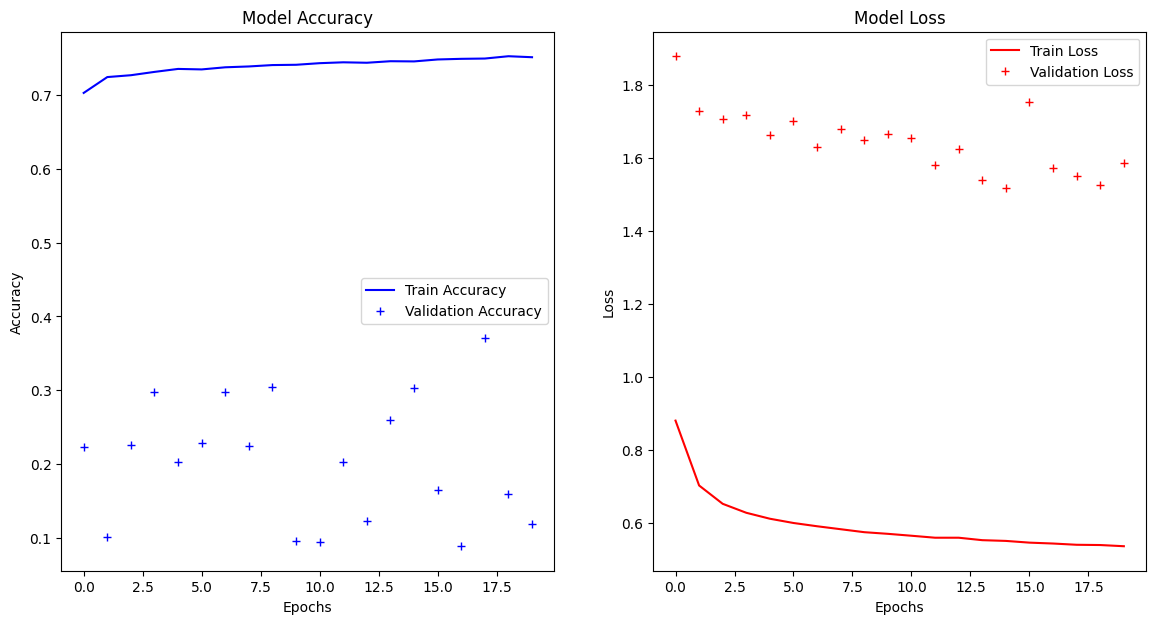

In [19]:
accuracyGraph(history)

5854/5854 [==============================] - 54s 9ms/step
              precision    recall  f1-score   support

           0       0.74      0.06      0.11      8603
           1       0.07      0.72      0.13       814
           2       0.10      0.00      0.00      1764
           3       0.02      0.10      0.04       291
           4       0.02      0.14      0.04       236

    accuracy                           0.10     11708
   macro avg       0.19      0.20      0.06     11708
weighted avg       0.56      0.10      0.09     11708

[[ 490 6072   16  905 1120]
 [  42  587    2   89   94]
 [ 102 1240    2  197  223]
 [  19  198    1   28   45]
 [  13  164    0   26   33]]


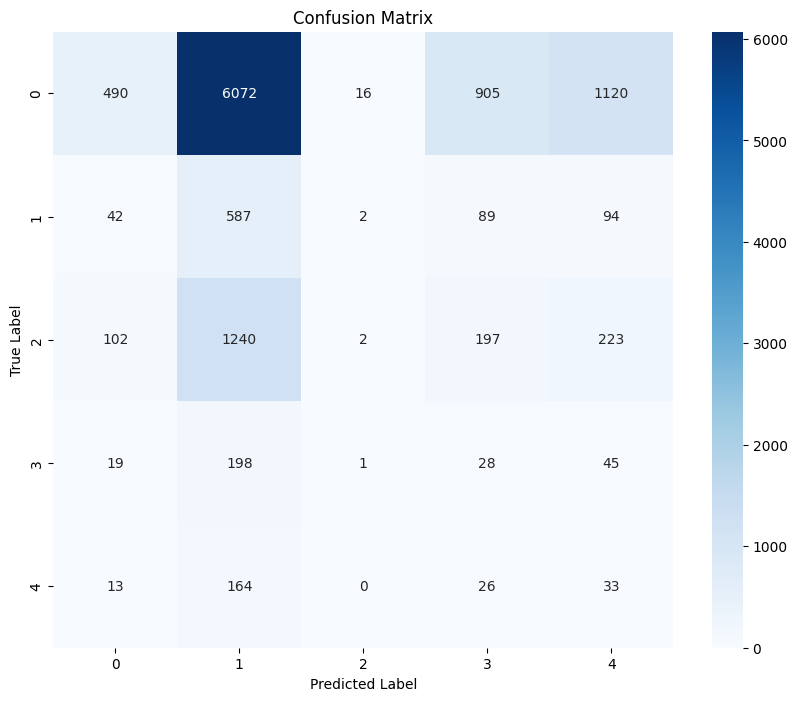

In [20]:
show_confusion_matrix(model)

In [21]:
_metrices = model.evaluate(test_generator)
print("Test Metrices", _metrices)

5854/5854 [==============================] - 82s 14ms/step - loss: 1.6124 - accuracy: 0.1135 - auc_1: 0.5381 - balanced_accuracy: 0.1135 - fscore: 0.0794 - precision_1: 0.0898 - recall_1: 0.0190
Test Metrices [1.6124178171157837, 0.11351212859153748, 0.5381343960762024, 0.11351212859153748, 0.07937661558389664, 0.08980582654476166, 0.01896139420568943]


In [22]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:15]:  # Adjust the index as needed
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
history = model.fit(
    combined_train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

Epoch 1/20


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12296/12296 [==============================] - 741s 60ms/step - loss: 0.3069 - accuracy: 0.9040 - auc_1: 0.9664 - balanced_accuracy: 0.8452 - fscore: 0.7917 - precision_1: 0.8803 - recall_1: 0.7802 - val_loss: 0.8437 - val_accuracy: 0.7341 - val_auc_1: 0.9057 - val_balanced_accuracy: 0.7341 - val_fscore: 0.6700 - val_precision_1: 0.7348 - val_recall_1: 0.7332
Epoch 2/20
12296/12296 [==============================] - 765s 62ms/step - loss: 0.2847 - accuracy: 0.9091 - auc_1: 0.9888 - balanced_accuracy: 0.8519 - fscore: 0.7980 - precision_1: 0.9140 - recall_1: 0.9043 - val_loss: 0.8263 - val_accuracy: 0.7267 - val_auc_1: 0.9106 - val_balanced_accuracy: 0.7267 - val_fscore: 0.6611 - val_precision_1: 0.7379 - val_recall_1: 0.7171
Epoch 3/20
12296/12296 [==============================] - 767s 62ms/step - loss: 0.2743 - accuracy: 0.9103 - auc_1: 0.9897 - balanced_accuracy: 0.8540 - fscore: 0.7994 - precision_1: 0.9204 - recall_1: 0.9019 - val_loss: 0.7880 - val_accuracy: 0.7386 - val_auc_1: 0

epochs 20


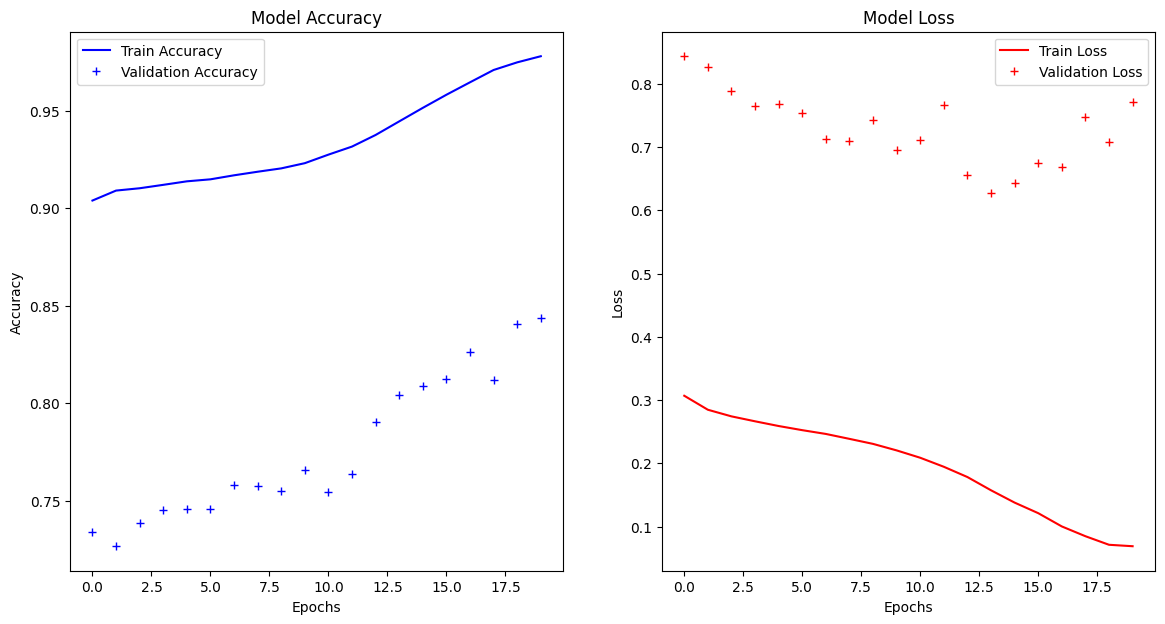

In [23]:
accuracyGraph(history)

5854/5854 [==============================] - 55s 9ms/step
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      8603
           1       0.07      0.04      0.05       814
           2       0.17      0.15      0.16      1764
           3       0.05      0.02      0.03       291
           4       0.03      0.02      0.02       236

    accuracy                           0.62     11708
   macro avg       0.21      0.21      0.21     11708
weighted avg       0.57      0.62      0.59     11708

[[6896  338 1155  106  108]
 [ 640   33  121   10   10]
 [1397   61  267   18   21]
 [ 229    9   40    7    6]
 [ 186   10   34    2    4]]


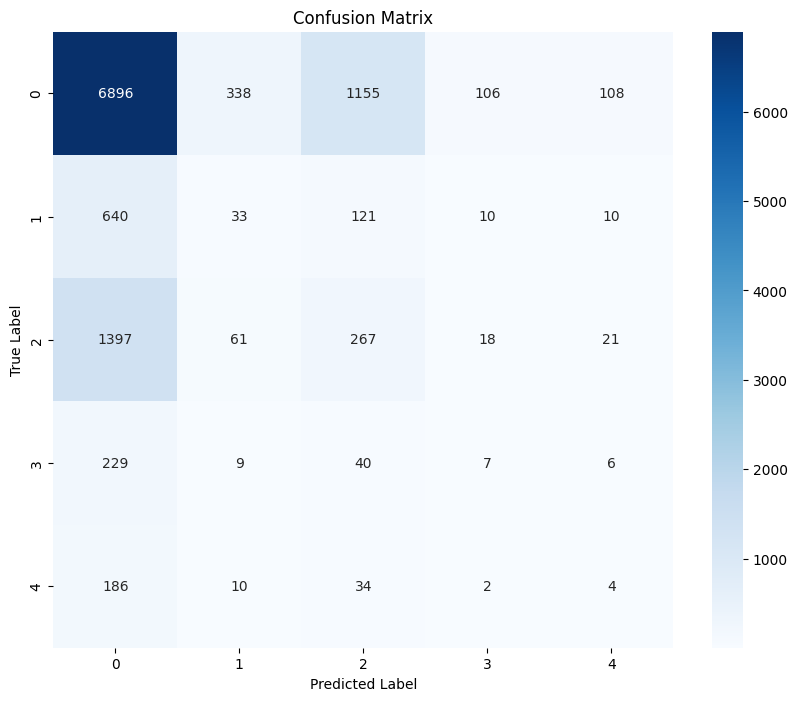

In [24]:
show_confusion_matrix(model)

In [25]:
_metrices = model.evaluate(test_generator)
print("Test Metrices", _metrices)

5854/5854 [==============================] - 81s 14ms/step - loss: 1.4348 - accuracy: 0.7229 - auc_1: 0.8968 - balanced_accuracy: 0.7229 - fscore: 0.6574 - precision_1: 0.7302 - recall_1: 0.7150
Test Metrices [1.4348337650299072, 0.7229244709014893, 0.8968378901481628, 0.7229244709014893, 0.6574309468269348, 0.730198860168457, 0.714981198310852]
